In [91]:
import urbs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_style(style="whitegrid")

color_dict = {
    #Generation
    'Biomass power plants': '#00B050',
    'Coal power plants': '#7F7F7F',
    'Gas power plants': '#ED7D31',
    'Geothermal power plants': '#385723',
    'Hydro power plants': '#1F4E79',
    'Nuclear power plants': '#BF9000',
    'Oil power plants': '#843C0C',
    'Onshore wind parks': '#9DC3E6',
    'Photovoltaics': '#F4EF11',
    'Others': '#3B3838',
    
    # Consumption
    'Electric chargers': '#0070C0',
    'Electricity (end-use)': '#00B0F0',
    'Process heating 100+ (electric heaters)': '#C55A11',
    'Process heating 100- (heat pumps)': '#BF9000',
    'Process heating 200+ (electric heaters)': '#843C0C',
    'Space heating (heat pumps)': '#548235',
    'Curtailment': '#767171'
}

In [92]:
# Load data for all years

years = [
         2025, 
         2030, 
         2035, 
         2040, 
         2045, 
         2050]

df = {}
for year in years:
    df[year] = urbs.load(f"myopic/output/output_bayern_{year}.h5")._result

In [212]:
year = 2050

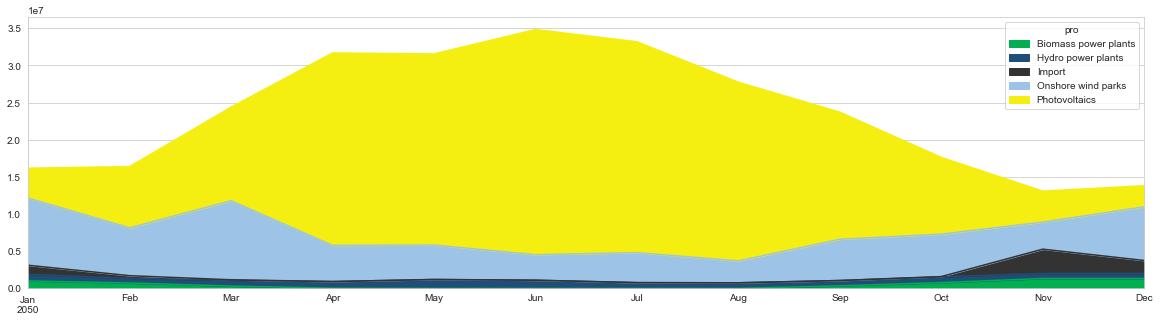

In [213]:
# Electricity generation

gen = (df[year]['e_pro_out']
 .unstack()['Elec']
 .dropna()
 .unstack()
 .replace(0, np.nan).dropna(axis = 1, how = "all")
 .replace(np.nan, 0)
 .reset_index()
 .drop(['t', 'stf', 'sit'], axis = 1)
 .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
 )

gen.resample("M").sum().plot(kind = "area", stacked = True, color = [color_dict.get(x, '#333333') for x in gen.columns])

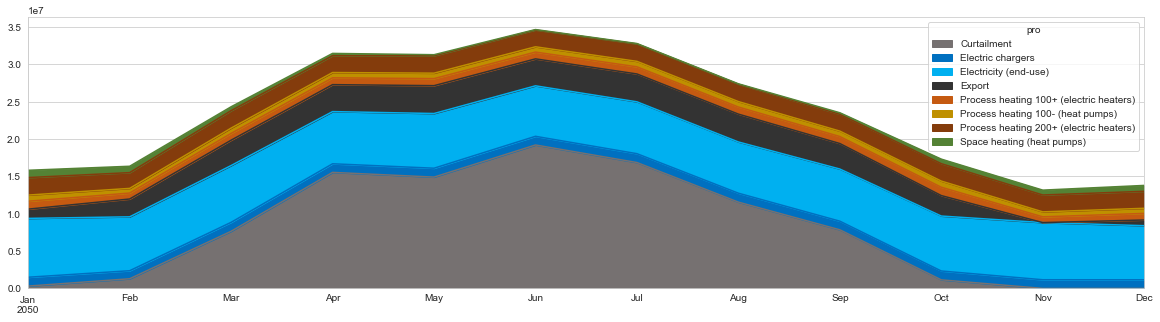

In [214]:
# Electricity consumption

con = (df[year]['e_pro_in']
 .unstack()['Elec']
 .dropna()
 .unstack()
 .replace(0, np.nan).dropna(axis = 1, how = "all")
 .replace(np.nan, 0)
 .reset_index()
 .drop(['t', 'stf', 'sit'], axis = 1)
 .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
 )

con.resample('M').sum().plot(kind = "area", stacked = True, color = [color_dict.get(x, '#333333') for x in con.columns])

In [215]:
# Storage charging dataframe

dfs = []
for col in df[year]['e_sto_in'].unstack().columns:
    i = (df[year]['e_sto_in']
            .unstack()[col]
            .unstack()
            .dropna(axis = 1, how = 'all')
            .reset_index()
            .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
            .drop(['t', 'stf', 'sit'], axis = 1)
            )
    dfs.append(i)

e_sto_in = pd.concat(dfs, axis = 1)

In [216]:
# Storage discharging dataframe

dfs = []
for col in df[year]['e_sto_out'].unstack().columns:
    i = (df[year]['e_sto_out']
            .unstack()[col]
            .unstack()
            .dropna(axis = 1, how = 'all')
            .reset_index()
            .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
            .drop(['t', 'stf', 'sit'], axis = 1)
            )
    dfs.append(i)

e_sto_out = pd.concat(dfs, axis = 1)

In [249]:
# Electricity price

price = (df[year]["res_vertex"]
 .unstack()["Stock"]
 .unstack()
 .replace(0, np.nan).dropna(axis = 1, how = "all")
 .replace(np.nan, 0)["Elec"]
 .reset_index()
 .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
 .drop(['t', 'stf', 'sit'], axis = 1)
 )

price.describe()

,Elec
count,8760.000000
mean,309.260821
std,1750.682248
min,0.000000
25%,0.000003
50%,0.205284
75%,22.526052
max,15435.114459


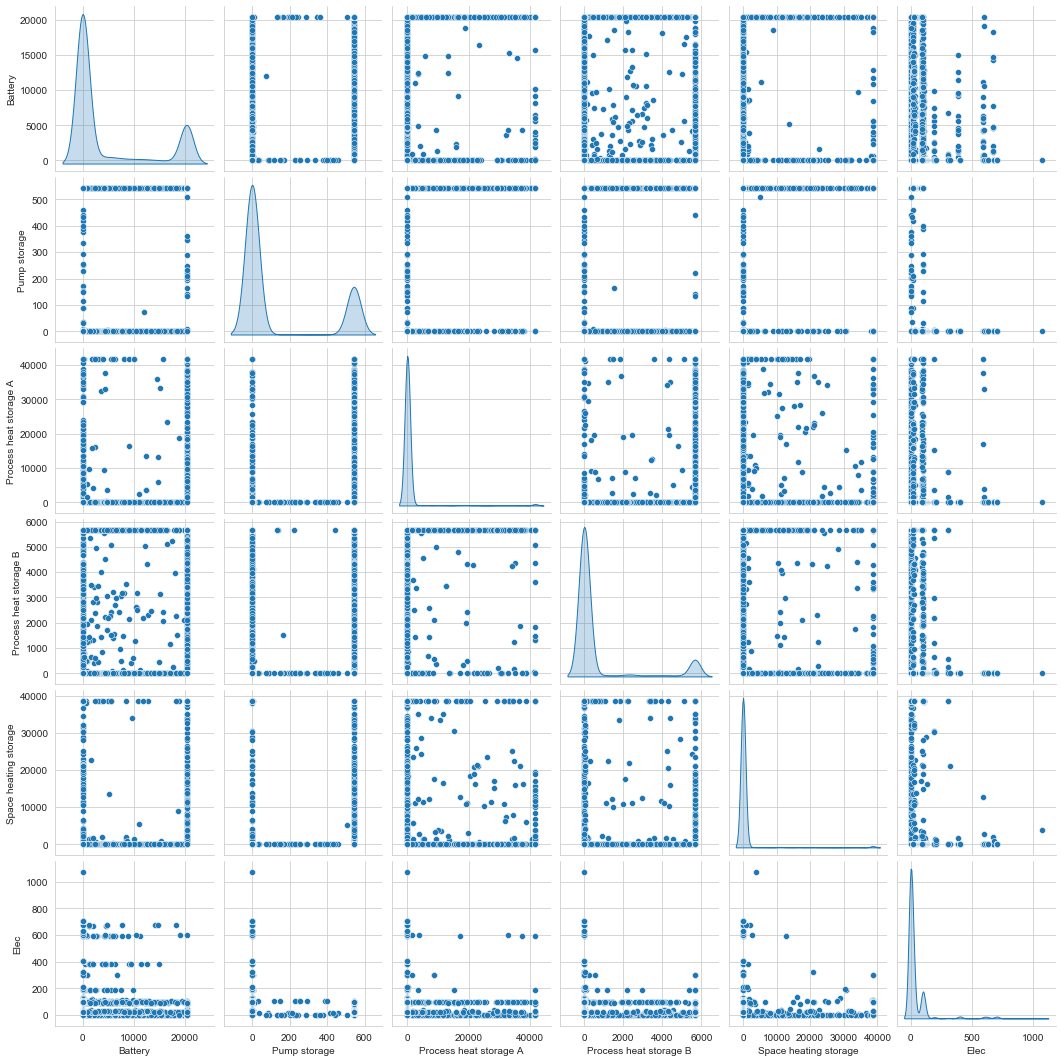

In [247]:
sns.pairplot(e_sto_in.join(price), diag_kind = "kde")

Text(0.5, 0.98, 'Load duration curves of energy storages')

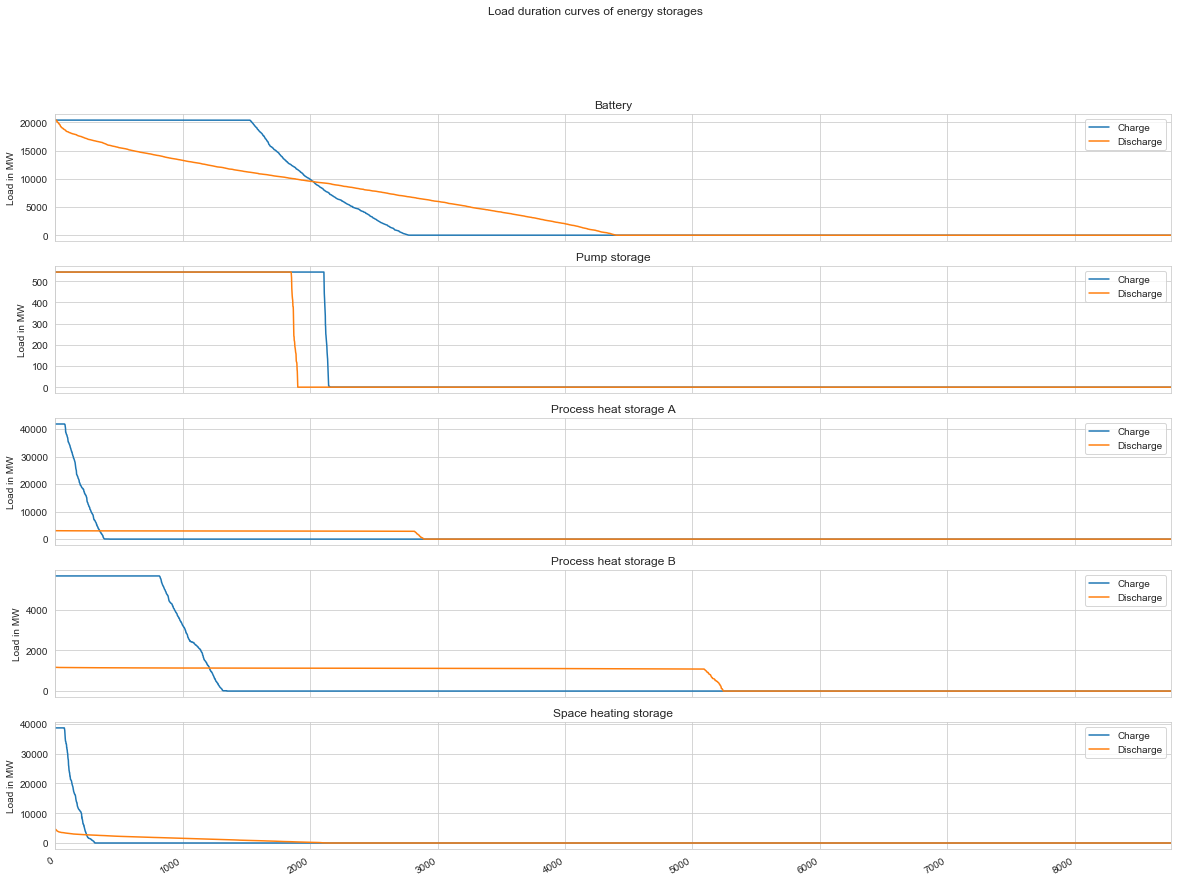

In [217]:
# Plotting load duration curves for energy storages

fig, axs = plt.subplots(len(e_sto_in.columns), 1, figsize = (20, len(e_sto_in.columns)*3), sharex = True)

for idx, tech in enumerate(e_sto_in.columns):

    e_sto_in[tech].sort_values(ascending = False).plot(use_index = False, ax = axs[idx])
    e_sto_out[tech].sort_values(ascending = False).plot(use_index = False, ax = axs[idx])
    axs[idx].set_title(tech)
    axs[idx].set_ylabel('Load in MW')
    axs[idx].legend(['Charge', 'Discharge'])

fig.suptitle(f'Load duration curves of energy storages {year}')

Text(0.5, 0.98, 'Load duration curves of consumption')

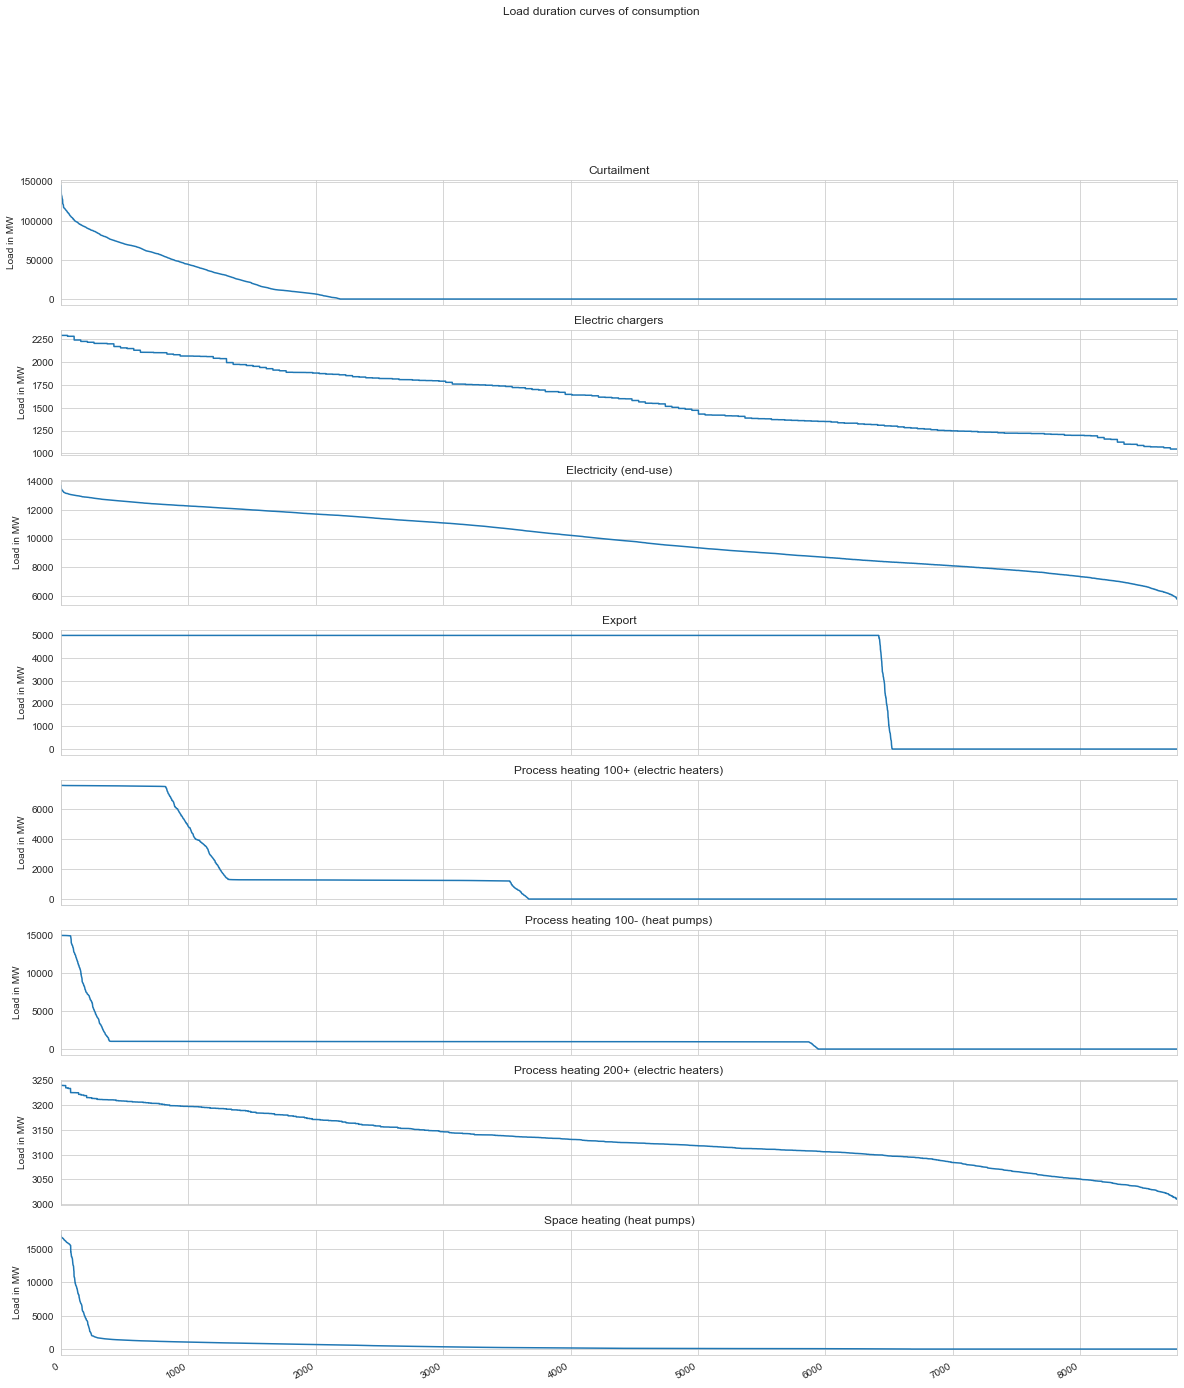

In [218]:
# Plotting load duration curves for energy consumption technologies

fig, axs = plt.subplots(len(con.columns), 1, figsize = (20, len(con.columns)*3), sharex = True)

for idx, tech in enumerate(con.columns):

    con[tech].sort_values(ascending = False).plot(use_index = False, ax = axs[idx])
    axs[idx].set_title(tech)
    axs[idx].set_ylabel('Load in MW')

fig.suptitle(f'Load duration curves of consumption {year}')

Text(0.5, 0.98, 'Load duration curves of generation')

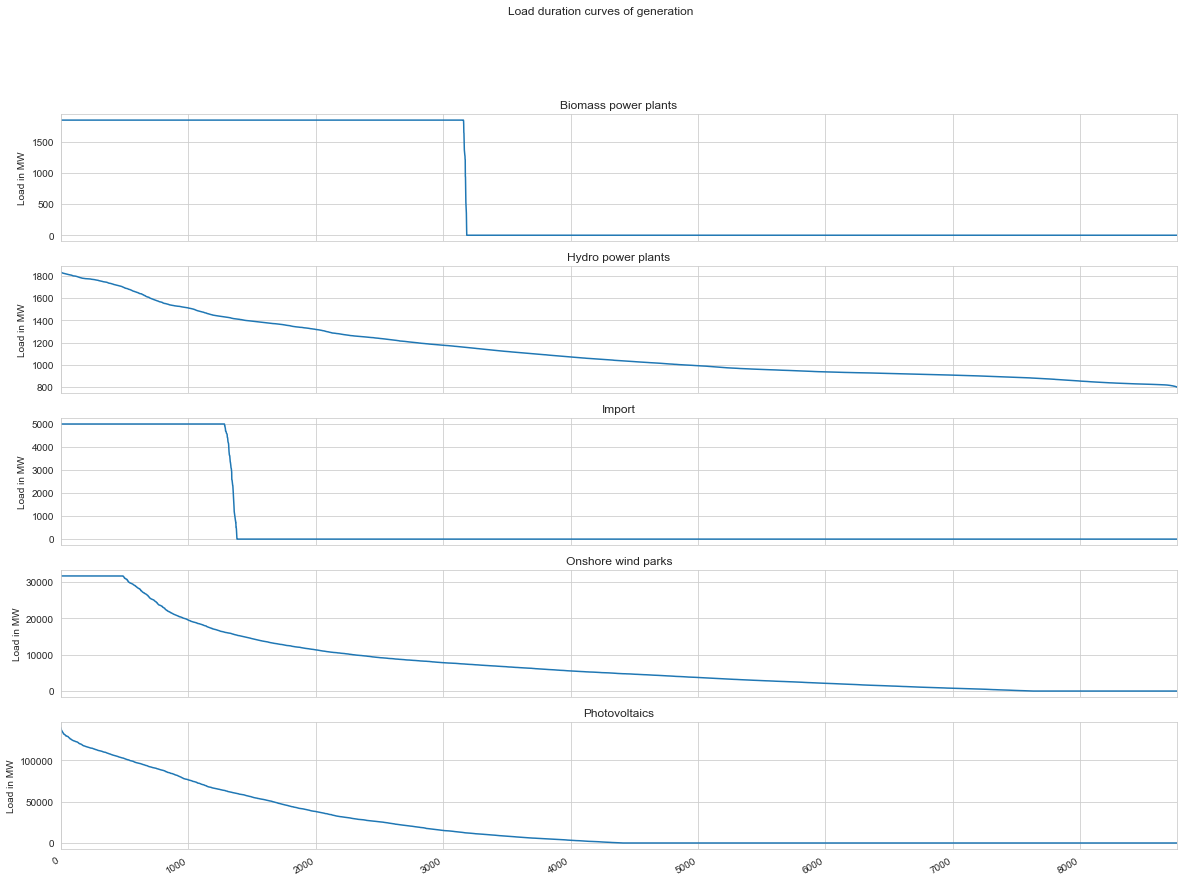

In [219]:
# Plotting load duration curves for energy generation technologies

fig, axs = plt.subplots(len(gen.columns), 1, figsize = (20, len(gen.columns)*3), sharex = True)

for idx, tech in enumerate(gen.columns):

    gen[tech].sort_values(ascending = False).plot(use_index = False, ax = axs[idx])
    axs[idx].set_title(tech)
    axs[idx].set_ylabel('Load in MW')

fig.suptitle(f'Load duration curves of generation {year}')